In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,f1_score,recall_score,precision_score,accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [19]:
# Load the dataset
data_raw = pd.read_csv("train.csv")

In [20]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [21]:
data_raw.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [22]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [23]:
# Shape of dataset
data_raw.shape

(45593, 20)

In [71]:
def calculate_picked_time(row):
    # Add a day offset if 'Time_Order_picked' is less than 'Time_Orderd'
    if row['Time_Order_picked'] < row['Time_Orderd']:
        return row['Order_Date'] + pd.DateOffset(days=1) + row['Time_Order_picked']
    else:
        return row['Order_Date'] + row['Time_Order_picked']

In [72]:
# Calculate new feature order_prepare_time
def calculate_time_diff(dataframe: pd.DataFrame):

    # print("Inside calculate_time_diff function")

    df = dataframe.copy()
    # print(df.iloc[0].to_dict())
    # Ensure 'Order_Date' is in datetime format
    df['Order_Date'].head()
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y') #

    # Convert 'Time_Orderd' and 'Time_Order_picked' to timedelta
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])

    df['Time_Order_picked_formatted'] = df.apply(calculate_picked_time, axis=1)

    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']

    # Ensure both columns are datetime before performing subtraction
    df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'])
    df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'])

    # Calculate the order preparation time in minutes
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60

    # Handle null values by filling with the median
    df['order_prepare_time'] = df['order_prepare_time'].fillna(df['order_prepare_time'].median())

    # Drop all the time & date related columns
    df.drop(['Time_Ordered_formatted', 'Time_Order_picked_formatted'], axis=1, inplace=True)
    df["Order_Date"] = dataframe['Order_Date']
    df["Time_Orderd"] = dataframe['Time_Orderd']
    df['Time_Order_picked'] = dataframe['Time_Order_picked']

    return df

In [25]:
# using haversine method
def haversine_distance(loc_list):
    # earth's radius in km
    R = 6371.0

    # convert lat and lon from deg to radians
    lat1,lon1,lat2,lon2 = map(np.radians,loc_list)
    # diff between lat and lon
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    # applying haversine formula
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c
    return round(d,2)

In [73]:
def rename_label(dataframe: pd.DataFrame):
    df = dataframe.copy()
    return df

In [74]:
def add_new_features(dataframe: pd.DataFrame):

    df = dataframe.copy()

    df["Order_Date_tmp"] = pd.to_datetime(df["Order_Date"], format='%d-%m-%Y')

    # Add new features
    df["day_of_week"] = df["Order_Date_tmp"].dt.dayofweek # monday = 0 and sunday = 6
    df["is_weekend"] = df["day_of_week"].apply(lambda x:1 if x in [5,6] else 0) # 5 = saturday and 6 = sunday
    df["quarter"] = df["Order_Date_tmp"].dt.quarter
    df['yr'] = df["Order_Date_tmp"].dt.year
    df['mnth'] = df["Order_Date_tmp"].dt.month_name()
    df.drop(['Order_Date_tmp'], axis=1, inplace=True)

    return df

In [75]:
def data_munging(dataframe: pd.DataFrame):
    df = dataframe.copy()

    df["Weatherconditions"] = df["Weatherconditions"].replace("nan", np.nan, regex=True).replace("NaN", np.nan, regex=True)
    df["Road_traffic_density"] = df["Road_traffic_density"].replace("nan", np.nan, regex=True).replace("NaN", np.nan, regex=True)
    df["Festival"] = df["Festival"].replace("nan", np.nan, regex=True).replace("NaN", np.nan, regex=True)
    df["City_area"] = df["City_area"].replace("nan", np.nan, regex=True).replace("NaN", np.nan, regex=True)
    df["Delivery_person_Age"] = df["Delivery_person_Age"].replace("nan", np.nan, regex=True).replace("NaN", np.nan, regex=True)
    df["Delivery_person_Ratings"] = df["Delivery_person_Ratings"].replace("nan", np.nan, regex=True).replace("NaN", np.nan, regex=True)

    df["Delivery_person_Age"] = df["Delivery_person_Age"].fillna(df["Delivery_person_Age"].astype("float").median())
    median_rating = df["Delivery_person_Ratings"].astype("float").median()
    df["Delivery_person_Ratings"] = df["Delivery_person_Ratings"].fillna(median_rating)
    df["Delivery_person_Ratings"] = df["Delivery_person_Ratings"].replace(6, median_rating)

    # For categorical columns use mode as imputation for np.nan
    cols = ["Weatherconditions","Road_traffic_density","City_area","Festival"]
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    #Derive new column city from Delivery_person_ID
    df["City"] = df["Delivery_person_ID"].str.split("RES").str[0].astype(str)

    # Removing condition word from the data
    df["Weatherconditions"] = df["Weatherconditions"].str.split(" ").str[-1]

    return df

In [76]:
def pre_pipeline_preparation(*, data_frame: pd.DataFrame) -> pd.DataFrame:

    # Strip spaces from the object type  columns
    data_frame = data_frame.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    #Derive order_prepare_time
    data_frame = calculate_time_diff(dataframe=data_frame)

    data_frame = add_new_features(dataframe=data_frame)

    # data_frame = rename_label(dataframe = data_frame )

    #Rename city and Time_taken columns
    data_frame.rename(columns = {"City":"City_area","Time_taken(min)":"Time_taken"},inplace=True)

    #Pre Pipeline data munging
    data_frame = data_munging(dataframe = data_frame)

    #Calcuate the distance between Restaurant and Delivery location
    loc_cols = ["Restaurant_latitude","Restaurant_longitude","Delivery_location_latitude","Delivery_location_longitude"]

    #To fix error for predict.py TypeError: ufunc 'radians' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
    data_frame['Restaurant_latitude'] = pd.to_numeric(data_frame['Restaurant_latitude'], errors='coerce')
    data_frame['Restaurant_longitude'] = pd.to_numeric(data_frame['Restaurant_longitude'], errors='coerce')
    data_frame['Delivery_location_latitude'] = pd.to_numeric(data_frame['Delivery_location_latitude'], errors='coerce')
    data_frame['Delivery_location_longitude'] = pd.to_numeric(data_frame['Delivery_location_longitude'], errors='coerce')

    distance = []
    for i in range(len(data_frame[loc_cols[0]])):
        location_list = [data_frame[loc_cols[j]][i] for j in range(len(loc_cols))]
        distance.append(haversine_distance(location_list))
    data_frame["Distance"] = distance

    # Issue while doing predction as it expects float
    data_frame[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']] = data_frame[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']].astype(str)

    data_frame['Time_taken'] = data_frame['Time_taken'].str.replace(r'\(min\)', '', regex=True).astype(float)  # Ensure target variable is float

    # Strip spaces from the object type  columns
    data_frame = data_frame.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    # Drop unnecessary fields
    for field in unused_fields:
        if field in data_frame.columns:
            data_frame.drop(labels = field, axis=1, inplace=True)

    return data_frame

In [31]:
# To remove the rows with zero lat and long
def drop_zero_lat_long(data):
    dataframe = data[-((data["Restaurant_latitude"]==0.0) & (data["Restaurant_longitude"]==0.0)) ]
    return dataframe

In [32]:
data = drop_zero_lat_long(data_raw)

In [33]:
data.shape

(41953, 20)

In [34]:
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City_area', 'City', 'day_of_week', 'is_weekend', 'quarter', 'yr', 'mnth', 'Distance', 'order_prepare_time']

In [35]:
target = ['Time_taken']

In [36]:
unused_fields = ['ID', 'Order_Date', 'Time_Orderd', 'Delivery_person_ID']

In [37]:
data.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [38]:
def load_dataset(*, file_name: str) -> pd.DataFrame:
    dataframe = pd.read_csv(file_name)
    transformed = pre_pipeline_preparation(data_frame = dataframe)
    return transformed

In [39]:
# Read the data and pass through pre pipeline preparation
prep_data = load_dataset(file_name = 'train.csv')

In [40]:
prep_data.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Time_Order_picked', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City_area',
       'Time_taken', 'order_prepare_time', 'day_of_week', 'is_weekend',
       'quarter', 'yr', 'mnth', 'City', 'Distance'],
      dtype='object')

In [41]:
prep_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,...,City_area,Time_taken,order_prepare_time,day_of_week,is_weekend,quarter,yr,mnth,City,Distance
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:45:00,Sunny,High,2,...,Urban,24.0,15.0,5,1,1,2022,March,INDO,3.03
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:50:00,Stormy,Jam,2,...,Metropolitian,33.0,5.0,4,0,1,2022,March,BANG,20.18


In [43]:
weather_mappings = {
    "Sunny": 0,
    "Stormy": 1,
    "Sandstorms": 2,
    "Cloudy": 3,
    "Fog": 4,
    "Windy": 5
}

traff_den_mappings = {
    "High": 0,
    "Jam": 1,
    "Low": 2,
    "Medium": 3
}

order_type_mappings = {
    "Snack": 0,
    "Drinks": 1,
    "Buffet": 2,
    "Meal": 3
}

vehicle_mappings = {
    "motorcycle": 0,
    "scooter": 1,
    "electric_scooter": 2,
    "bicycle": 3
}

festival_mappings = {
    "No": 0,
    "Yes": 1
}

city_area_mappings = {
    "Urban": 0,
    "Metropolitian": 1,
    "Semi-Urban": 2
}

city_mappings = {
    "INDO": 0,
    "BANG": 1,
    "COIMB": 2,
    "CHEN": 3,
    "HYD": 4,
    "RANCHI": 5,
    "MYS": 6,
    "DEH": 7,
    "KOC": 8,
    "PUNE": 9,
    "LUDH": 10,
    "KNP": 11,
    "MUM": 12,
    "KOL": 13,
    "JAP": 14,
    "SUR": 15,
    "GOA": 16,
    "AURG": 17,
    "AGR": 18,
    "VAD": 19,
    "ALH": 20,
    "BHP": 21
}

mnth_mappings = {
    "January": 0,
    "February": 1,
    "March": 2,
    "April": 3,
    "May": 4,
    "June": 5,
    "July": 6,
    "August": 7,
    "September": 8,
    "October": 9,
    "November": 10,
    "December": 11
}

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

In [46]:
class Mapper(BaseEstimator, TransformerMixin):
    """
    Ordinal categorical variable mapper:
    Treat column as Ordinal categorical variable, and assign values accordingly
    """

    def __init__(self, variable:str, mappings:dict):

        if not isinstance(variable, str):
            raise ValueError("variable name should be a string")

        self.variable = variable
        self.mappings = mappings

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need the fit statement to accomodate the sklearn pipeline
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X[self.variable] = X[self.variable].map(self.mappings).astype(int)

        return X


class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Change the outlier values:
        - to upper-bound, if the value is higher than upper-bound, or
        - to lower-bound, if the value is lower than lower-bound respectively.
    """

    def __init__(self, variable:str):

        if not isinstance(variable, str):
            raise ValueError("variable name should be a string")

        self.variable = variable

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need the fit statement to accomodate the sklearn pipeline
        X = X.copy()
        q1 = X.describe()[self.variable].loc['25%']
        q3 = X.describe()[self.variable].loc['75%']
        iqr = q3 - q1
        self.lower_bound = q1 - (1.5 * iqr)
        self.upper_bound = q3 + (1.5 * iqr)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        for i in X.index:
            if X.loc[i, self.variable] > self.upper_bound:
                X.loc[i, self.variable]= self.upper_bound
            if X.loc[i, self.variable] < self.lower_bound:
                X.loc[i, self.variable]= self.lower_bound

        return X


class WeekdayOneHotEncoder(BaseEstimator, TransformerMixin):
    """ One-hot encode weekday column """

    def __init__(self, variable:str):

        if not isinstance(variable, str):
            raise ValueError("variable name should be a string")

        self.variable = variable
        self.encoder = OneHotEncoder(sparse_output=False)

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need the fit statement to accomodate the sklearn pipeline
        X = X.copy()
        self.encoder.fit(X[[self.variable]])
        # Get encoded feature names
        self.encoded_features_names = self.encoder.get_feature_names_out([self.variable])

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        encoded_weekdays = self.encoder.transform(X[[self.variable]])
        # Append encoded weekday features to X
        X[self.encoded_features_names] = encoded_weekdays

        # drop 'weekday' column after encoding
        X.drop(self.variable, axis=1, inplace=True)

        return X

In [47]:
prep_data_1 = prep_data.copy()

In [48]:
prep_data_1["Weatherconditions"] = prep_data["Weatherconditions"].map(weather_mappings)
prep_data_1["Road_traffic_density"] = prep_data["Road_traffic_density"].map(traff_den_mappings)
prep_data_1["Type_of_order"] = prep_data["Type_of_order"].map(order_type_mappings)
prep_data_1["Type_of_vehicle"] = prep_data["Type_of_vehicle"].map(vehicle_mappings)
prep_data_1["City_area"] = prep_data["City_area"].map(city_area_mappings)
prep_data_1["Festival"] = prep_data["Festival"].map(festival_mappings)
prep_data_1["mnth"] = prep_data["mnth"].map(mnth_mappings)

In [49]:
encoder = LabelEncoder()
prep_data_1['City'] = encoder.fit_transform(prep_data['City'])

In [50]:
prep_data_1.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,...,City_area,Time_taken,order_prepare_time,day_of_week,is_weekend,quarter,yr,mnth,City,Distance
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:45:00,0,0,2,...,0,24.0,15.0,5,1,1,2022,2,10,3.03
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:50:00,1,1,2,...,1,33.0,5.0,4,0,1,2022,2,3,20.18


In [51]:
# Convert all object columns to float as XGboost throws error for object datatypes
prep_data_1 = prep_data_1.apply(pd.to_numeric, errors='coerce')

In [52]:
prep_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          43739 non-null  float64
 1   Delivery_person_Ratings      43685 non-null  float64
 2   Restaurant_latitude          45593 non-null  float64
 3   Restaurant_longitude         45593 non-null  float64
 4   Delivery_location_latitude   45593 non-null  float64
 5   Delivery_location_longitude  45593 non-null  float64
 6   Time_Order_picked            0 non-null      float64
 7   Weatherconditions            45593 non-null  int64  
 8   Road_traffic_density         45593 non-null  int64  
 9   Vehicle_condition            45593 non-null  int64  
 10  Type_of_order                45593 non-null  int64  
 11  Type_of_vehicle              45593 non-null  int64  
 12  multiple_deliveries          44600 non-null  float64
 13  Festival        

In [53]:
    # divide train and test
    X_train, X_test, y_train, y_test = train_test_split(

        prep_data_1[features],     # predictors
        prep_data_1[target],       # target
        test_size = 0.2,
        random_state= 42,   # set the random seed here for reproducibility
    )


In [54]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36474, 22)
(36474, 1)
(9119, 22)
(9119, 1)


In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameters grid
param_grid = {
    'n_estimators': [10,20,40,50,100],
    'max_depth': [3,5,7,9]
    }

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_model.predict(X_test)
print("R² Score:", best_model.score(X_test, y_test))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best hyperparameters: {'max_depth': 9, 'n_estimators': 100}
R² Score: 0.8156107268286192


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define model
rf = xgb.XGBRegressor(random_state=42)

# Define hyperparameters grid
param_grid = {
    'n_estimators': [10,20,40,50,100],
    'max_depth': [3,5,7,9]
    }

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_model.predict(X_test)
print("R² Score:", best_model.score(X_test, y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'max_depth': 9, 'n_estimators': 10}
R² Score: 0.8256694674491882


In [58]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_percentage_error

In [64]:
# Get feature importance scores
importance = best_model.feature_importances_

# Display feature importance
for feature_name, score in zip(features, importance):
    print(f"{feature_name}: {score:.4f}")

Delivery_person_Age: 0.0414
Delivery_person_Ratings: 0.2150
Restaurant_latitude: 0.0032
Restaurant_longitude: 0.0019
Delivery_location_latitude: 0.0024
Delivery_location_longitude: 0.0025
Weatherconditions: 0.1001
Road_traffic_density: 0.1406
Vehicle_condition: 0.1289
Type_of_order: 0.0018
Type_of_vehicle: 0.0022
multiple_deliveries: 0.1880
Festival: 0.0838
City_area: 0.0173
City: 0.0026
day_of_week: 0.0021
is_weekend: 0.0000
quarter: 0.0014
yr: 0.0000
mnth: 0.0033
Distance: 0.0599
order_prepare_time: 0.0018


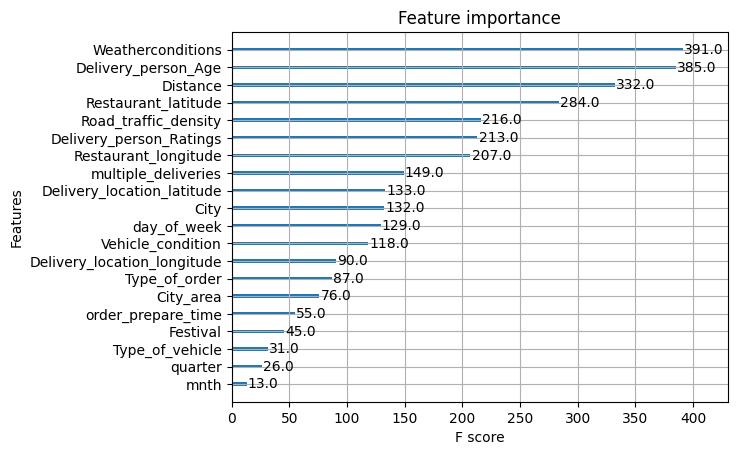

In [66]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plot_importance(best_model, importance_type="weight")
plt.show()


In [67]:
# Model Development
xgb_model = xgb.XGBRegressor(
        n_estimators=10,  # Number of boosting rounds (trees)
    max_depth=9,       # Maximum depth of the trees
    random_state=42     # Random seed for reproducibility

)

In [68]:
# Train the model on training data
xgb_model.fit(X_train, y_train)

# Inference: Predict on the test data
y_pred = xgb_model.predict(X_test)

In [69]:
# Metrics
print("R2 score:", r2_score(y_test, y_pred))
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print(f"Root mean squared error:{np.sqrt(mean_squared_error(y_test,y_pred))}")
print("Mean Absolute Pecentage error:",mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.8256694674491882
Mean squared error: 15.284973297609968
Root mean squared error:3.9096001454893017
Mean Absolute Pecentage error: 0.13704141616980686
